In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [34]:
df = pd.read_csv('../../data/downloads/freight_model_output_20250429_153346.csv')
df.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,multiple_commodities,priority_multiple_commodities,freight_per_invoice,standardization_status,error_summary,priority_failure_reasons,...,market_rate,xgs_applied_rate,xgs_raw_rate,freight_ratio_raw,freight_ratio_normal,rate_ratio_raw,rate_ratio_normal,market_cost_outlier,freight_ratio_raw_outlier,freight_ratio_normal_outlier
0,357863,SPN,1VNL,1485.67,True,False,191.13,SUCCESS,Standardization successful; Unsupported commod...,No priority errors found,...,0.098961,0.078207,0.078207,1.265368,1.265368,1.265361,1.265368,NORMAL,NORMAL,NORMAL
1,357870,SPCP,1VNL,6609.39,False,False,602.67,SUCCESS,Standardization successful,No priority errors found,...,0.070141,0.118680,0.118680,0.591015,0.591015,0.591017,0.591015,NORMAL,NORMAL,NORMAL


In [35]:
df = df.drop_duplicates(subset='invoice_id', keep='first')
df

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,multiple_commodities,priority_multiple_commodities,freight_per_invoice,standardization_status,error_summary,priority_failure_reasons,...,market_rate,xgs_applied_rate,xgs_raw_rate,freight_ratio_raw,freight_ratio_normal,rate_ratio_raw,rate_ratio_normal,market_cost_outlier,freight_ratio_raw_outlier,freight_ratio_normal_outlier
0,357863,SPN,1VNL,1485.67,True,False,191.13,SUCCESS,Standardization successful; Unsupported commod...,No priority errors found,...,0.098961,0.078207,0.078207,1.265368,1.265368,1.265361,1.265368,NORMAL,NORMAL,NORMAL
1,357870,SPCP,1VNL,6609.39,False,False,602.67,SUCCESS,Standardization successful,No priority errors found,...,0.070141,0.118680,0.118680,0.591015,0.591015,0.591017,0.591015,NORMAL,NORMAL,NORMAL
2,357875,SPTM,1CPT,331.22,False,False,524.66,SUCCESS,Standardization successful,No priority errors found,...,1.218479,1.184620,1.184620,1.028582,1.028582,1.028580,1.028582,NORMAL,NORMAL,NORMAL
3,362795,SPT,1VNL,121.16,False,False,59.13,SUCCESS,Standardization successful,No priority errors found,...,0.375410,0.239353,0.239353,1.568435,1.568435,1.568522,1.568435,NORMAL,NORMAL,NORMAL
4,367488,SPCP,1CPT,1893.27,False,False,1650.00,SUCCESS,Standardization successful,No priority errors found,...,0.670391,0.772832,0.772832,0.867447,0.867447,0.867449,0.867447,HIGH,NORMAL,NORMAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6482,1748714,SPHU,1VNL,450.07,False,False,994.30,SUCCESS,Standardization successful,No priority errors found,...,1.699394,0.245651,0.245651,6.917928,6.917928,6.917655,6.917928,HIGH,HIGH,HIGH
6483,1750108,SPN,1VNL,127.80,False,False,39.95,SUCCESS,Standardization successful,No priority errors found,...,0.240460,0.746088,0.115493,2.082030,0.322294,2.082414,0.322294,NORMAL,NORMAL,NORMAL
6484,1750403,SPW,1CPT,97.78,False,False,97.88,SUCCESS,Standardization successful,No priority errors found,...,0.770017,0.724995,0.724995,1.062101,1.062101,1.062093,1.062101,NORMAL,NORMAL,NORMAL
6485,1750508,DIT,1CPT,717.59,False,False,14668.40,SUCCESS,Standardization successful,No priority errors found,...,15.723999,0.690938,0.690938,22.757477,22.757477,22.757290,22.757477,HIGH,HIGH,HIGH


In [36]:
# === invoice_freight_utils.py (Updated with correct xgs_method_logic tie handling) ===

import pandas as pd
import numpy as np

def simulate_freight_cost_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 3 freight cost simulations:
    - ltl_only_cost: Cost if only LTL used
    - xgs_threshold_cost: XGS method using vendor threshold rules
    - optimal_cost: Theoretical best (min(FTL, LTL), ignoring thresholds)

    Handles fallback logic for zero rates and correctly resolves FTL vs LTL tie cases.
    """
    df = df.copy()

    # Step 1: Define vendor thresholds and fixed FTL truckload prices
    vendor_thresholds = {
        '1CBL': 2200,   # SQYD
        '1CPT': 2200,   # SQYD
        '1VNL': 20000   # LBS
    }

    fixed_ftl_prices = {
        '1CBL': 2100,   # Flat FTL truck rate
        '1CPT': 2100,
        '1VNL': 1500
    }

    # Step 2: Ensure required columns exist
    required_cols = ['invoice_commodity_quantity', 'new_commodity_group', 'rate', 'unit', 'raw_invoice_cost', 'invoice_freight_commodity_cost', 'minimum_applied']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Step 3: Compute LTL cost (respects minimum charge)
    df['ltl_only_cost'] = np.where(
        df['minimum_applied'] == True,
        df['invoice_freight_commodity_cost'],
        df['raw_invoice_cost']
    )

    # Step 4: Compute FTL cost (fixed per truckload)
    df['ftl_cost'] = df['new_commodity_group'].map(fixed_ftl_prices)

    # Step 5: Apply fallback logic for shipments with rate == 0
    def fallback_ftl_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['rate'] == 0 and row['invoice_commodity_quantity'] >= threshold:
            return row['ftl_cost']  # fallback to FTL flat rate
        elif row['rate'] == 0:
            return row['ltl_only_cost']  # fallback to LTL
        else:
            return row['ltl_only_cost']

    df['ltl_only_cost'] = df.apply(fallback_ftl_logic, axis=1)

    # Step 6: Apply vendor threshold logic for XGS method
    def xgs_cost_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return min(row['ftl_cost'], row['ltl_only_cost'])
        else:
            return row['ltl_only_cost']

    def xgs_method_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return 'FTL' if row['ftl_cost'] <= row['ltl_only_cost'] else 'LTL'
        else:
            return 'LTL'

    df['xgs_threshold_cost'] = df.apply(xgs_cost_logic, axis=1)
    df['xgs_method'] = df.apply(xgs_method_logic, axis=1)

    # Step 7: Fully optimized (ignores threshold)
    df['optimal_cost'] = df[['ftl_cost', 'ltl_only_cost']].min(axis=1)
    df['optimal_method'] = np.where(df['ftl_cost'] <= df['ltl_only_cost'], 'FTL', 'LTL')

    # Step 8: Flag when vendor threshold prevents optimal FTL
    df['ftl_blocked'] = (df['xgs_method'] == 'LTL') & (df['optimal_method'] == 'FTL')
    df['penalty_vs_optimal'] = df['xgs_threshold_cost'] - df['optimal_cost']

    return df


In [37]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

In [38]:
columns_output = ['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'freight_class','shipment_type','unit', 'rate','calibrated_market_freight_costs','market_rate',
       'invoice_freight_commodity_cost', 'raw_invoice_cost','minimum_applied',]

In [39]:
df2 = df[columns_output]
df2.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,freight_class,shipment_type,unit,rate,calibrated_market_freight_costs,market_rate,invoice_freight_commodity_cost,raw_invoice_cost,minimum_applied
0,357863,SPN,1VNL,1485.67,1M,LTL,LBS,0.078208,147.023077,0.098961,116.19,116.19,False
1,357870,SPCP,1VNL,6609.39,5M,LTL,LBS,0.118679,463.592308,0.070141,784.40,784.40,False


In [40]:
output= simulate_freight_cost_models(df2)

In [41]:
output.to_csv('../../data/downloads/output_freight_model_output_revised4.csv', index=False)


In [5]:
output

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,multiple_commodities,priority_multiple_commodities,freight_per_invoice,standardization_status,error_summary,priority_failure_reasons,...,freight_ratio_raw_outlier,freight_ratio_normal_outlier,ltl_only_cost,ftl_cost,xgs_threshold_cost,xgs_method,optimal_cost,optimal_method,ftl_blocked,penalty_vs_optimal
0,357863,SPN,1VNL,1485.67,True,False,191.13,SUCCESS,Standardization successful; Unsupported commod...,No priority errors found,...,NORMAL,NORMAL,116.19,1500,116.19,LTL,116.19,LTL,False,0.0
1,357870,SPCP,1VNL,6609.39,False,False,602.67,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,784.40,1500,784.40,LTL,784.40,LTL,False,0.0
2,357875,SPTM,1CPT,331.22,False,False,524.66,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,392.37,2100,392.37,LTL,392.37,LTL,False,0.0
3,362795,SPT,1VNL,121.16,False,False,59.13,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,29.00,1500,29.00,LTL,29.00,LTL,False,0.0
4,367488,SPCP,1CPT,1893.27,False,False,1650.00,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,1463.18,2100,1463.18,LTL,1463.18,LTL,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6482,1748714,SPHU,1VNL,450.07,False,False,994.30,SUCCESS,Standardization successful,No priority errors found,...,HIGH,HIGH,110.56,1500,110.56,LTL,110.56,LTL,False,0.0
6483,1750108,SPN,1VNL,127.80,False,False,39.95,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,95.35,1500,95.35,LTL,95.35,LTL,False,0.0
6484,1750403,SPW,1CPT,97.78,False,False,97.88,SUCCESS,Standardization successful,No priority errors found,...,NORMAL,NORMAL,70.89,2100,70.89,LTL,70.89,LTL,False,0.0
6485,1750508,DIT,1CPT,717.59,False,False,14668.40,SUCCESS,Standardization successful,No priority errors found,...,HIGH,HIGH,495.81,2100,495.81,LTL,495.81,LTL,False,0.0


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_freight_cost_models(df, quantity_col="invoice_commodity_quantity"):
    """
    Plots freight cost vs quantity for different cost models:
    - ltl_only_cost
    - ftl_cost (assumed fixed)
    - xgs_threshold_cost
    - optimal_cost

    Parameters:
    - df: DataFrame with required cost columns and quantity
    - quantity_col: name of the quantity column (default: 'invoice_commodity_quantity')

    Returns:
    - Matplotlib figure and axes objects
    """
    # Validate required columns
    required_cols = [
        quantity_col, "ltl_only_cost", "ftl_cost",
        "xgs_threshold_cost", "optimal_cost"
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    quantity = df[quantity_col]
    ltl_cost = df["ltl_only_cost"]
    ftl_cost = df["ftl_cost"]
    xgs_cost = df["xgs_threshold_cost"]
    optimal_cost = df["optimal_cost"]

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.scatter(quantity, ltl_cost, label="ltl_only_cost", alpha=0.7)
    ax.scatter(quantity, ftl_cost, label="ftl_cost", alpha=0.7)
    ax.scatter(quantity, xgs_cost, label="xgs_threshold_cost", color='green', alpha=0.7)
    ax.scatter(quantity, optimal_cost, label="optimal_cost", alpha=0.7)

    # Trendlines
    if len(df) >= 3:
        z_ltl = np.polyfit(quantity, ltl_cost, 2)
        z_optimal = np.polyfit(quantity, optimal_cost, 2)
        p_ltl = np.poly1d(z_ltl)
        p_optimal = np.poly1d(z_optimal)
        
        x_range = np.linspace(quantity.min(), quantity.max(), 500)
        ax.plot(x_range, p_ltl(x_range), "b--", label="Poly. (ltl_only_cost)")
        ax.plot(x_range, p_optimal(x_range), "c--", label="Poly. (optimal_cost)")
        ax.axhline(y=ftl_cost.mean(), color='orange', linestyle=':', label="Linear (ftl_cost)")

    ax.set_title("Freight Cost vs Quantity with Trend Lines")
    ax.set_xlabel("Quantity (SQYD or LBS)")
    ax.set_ylabel("Total Freight Cost ($)")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    return fig, ax


(<Figure size 864x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Freight Cost vs Quantity with Trend Lines'}, xlabel='Quantity (SQYD or LBS)', ylabel='Total Freight Cost ($)'>)

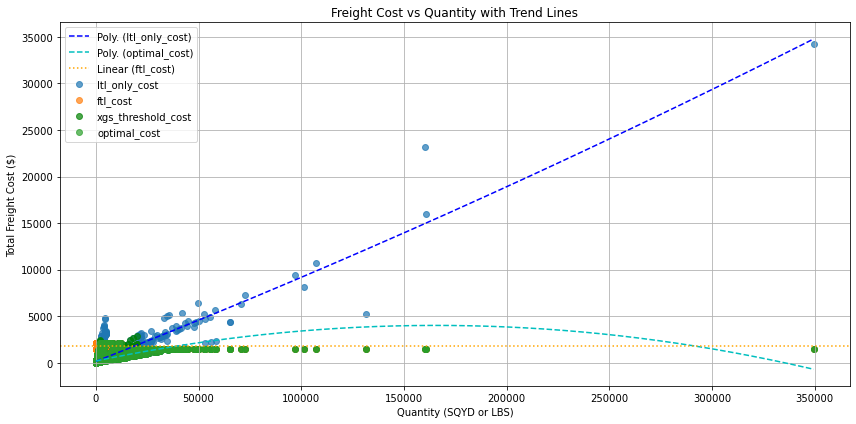

In [43]:
plot_freight_cost_models(output)

In [44]:
# === invoice_freight_utils.py ===

import pandas as pd
import numpy as np

def simulate_freight_cost_models(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds 3 freight cost simulations:
    - ltl_only_cost: Cost if only LTL used
    - xgs_threshold_cost: XGS method using vendor threshold rules
    - optimal_cost: Theoretical best (min(FTL, LTL), ignoring thresholds)

    Now supports site-specific dynamic FTL costs using distance, rate-per-mile, and minimum enforcement.
    """
    df = df.copy()

    # Step 1: Define vendor thresholds
    vendor_thresholds = {
        '1CBL': 2200,   # SQYD
        '1CPT': 2200,   # SQYD
        '1VNL': 20000   # LBS
    }

    # Define site-specific mileage and recommended truck type
    site_ftl_info = {
        'DIT': {'miles': 740, 'commodity': '1CPT', 'truck': 'Dry Van'},
        'SPW': {'miles': 453, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'SPN': {'miles': 20, 'commodity': '1CPT', 'truck': 'Dry Van'},
        'SPCP': {'miles': 804, 'commodity': '1CBL', 'truck': 'Flatbed'},
        'SPT': {'miles': 457, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'PVF': {'miles': 1050, 'commodity': '1CBL', 'truck': 'Flatbed'},
        'SPHU': {'miles': 792, 'commodity': '1CBL', 'truck': 'Flatbed'},
        'KUS': {'miles': 740, 'commodity': '1CPT', 'truck': 'Dry Van'},
        'SPTM': {'miles': 1844, 'commodity': '1VNL', 'truck': 'Dry Van'},
        'SPJ': {'miles': 346, 'commodity': '1VNL', 'truck': 'Dry Van'}
    }

    # Truck rates and minimum charges
    rate_per_mile = {'Dry Van': 1.952, 'Flatbed': 2.548}
    min_charge = {'Dry Van': 700, 'Flatbed': 900}

    # Step 2: Ensure required columns exist
    required_cols = [
        'invoice_commodity_quantity', 'new_commodity_group', 'rate', 'unit',
        'raw_invoice_cost', 'invoice_freight_commodity_cost', 'minimum_applied', 'site'
    ]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Step 3: Compute LTL cost (respects minimum charge)
    df['ltl_only_cost'] = np.where(
        df['minimum_applied'] == True,
        df['invoice_freight_commodity_cost'],
        df['raw_invoice_cost']
    )

    # Step 4: Compute FTL cost with site logic
    def calculate_ftl_cost(row):
        info = site_ftl_info.get(row['site'], None)
        if info is None:
            return np.nan
        truck_type = info['truck']
        miles = info['miles']
        rate = rate_per_mile[truck_type]
        minimum = min_charge[truck_type]
        return max(miles * rate, minimum)

    df['ftl_cost'] = df.apply(calculate_ftl_cost, axis=1)

    # Step 5: Fallback logic for rows with rate = 0
    def fallback_ftl_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['rate'] == 0 and row['invoice_commodity_quantity'] >= threshold:
            return row['ftl_cost']
        elif row['rate'] == 0:
            return row['ltl_only_cost']
        else:
            return row['ltl_only_cost']

    df['ltl_only_cost'] = df.apply(fallback_ftl_logic, axis=1)

    # Step 6: Apply XGS vendor logic
    def xgs_cost_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return min(row['ftl_cost'], row['ltl_only_cost'])
        else:
            return row['ltl_only_cost']

    def xgs_method_logic(row):
        threshold = vendor_thresholds.get(row['new_commodity_group'], np.inf)
        if row['invoice_commodity_quantity'] >= threshold:
            return 'FTL' if row['ftl_cost'] <= row['ltl_only_cost'] else 'LTL'
        else:
            return 'LTL'

    df['xgs_threshold_cost'] = df.apply(xgs_cost_logic, axis=1)
    df['xgs_method'] = df.apply(xgs_method_logic, axis=1)

    # Step 7: Fully optimized (ignores thresholds)
    df['optimal_cost'] = df[['ftl_cost', 'ltl_only_cost']].min(axis=1)
    df['optimal_method'] = np.where(df['ftl_cost'] <= df['ltl_only_cost'], 'FTL', 'LTL')

    # Step 8: Flag cases where threshold blocks optimal FTL use
    df['ftl_blocked'] = (df['xgs_method'] == 'LTL') & (df['optimal_method'] == 'FTL')
    df['penalty_vs_optimal'] = df['xgs_threshold_cost'] - df['optimal_cost']

    return df


In [45]:
output_df = simulate_freight_cost_models(df2)
output_df.head(2)

,invoice_id,site,new_commodity_group,invoice_commodity_quantity,freight_class,shipment_type,unit,rate,calibrated_market_freight_costs,market_rate,...,raw_invoice_cost,minimum_applied,ltl_only_cost,ftl_cost,xgs_threshold_cost,xgs_method,optimal_cost,optimal_method,ftl_blocked,penalty_vs_optimal
0,357863,SPN,1VNL,1485.67,1M,LTL,LBS,0.078208,147.023077,0.098961,...,116.19,False,116.19,700.000,116.19,LTL,116.19,LTL,False,0.0
1,357870,SPCP,1VNL,6609.39,5M,LTL,LBS,0.118679,463.592308,0.070141,...,784.40,False,784.40,2048.592,784.40,LTL,784.40,LTL,False,0.0
